In [ ]:
!git clone https://github.com/K-ssou/App_Profond_Geoguessr.git

fatal: destination path 'App_Profond_Geoguessr' already exists and is not an empty directory.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [ ]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat
from keras.preprocessing.image import ImageDataGenerator

NUM_AUGMENTED_IMAGES = 2

rgb_mean = np.zeros(3)
rgb_std = np.array(3)

def normalize(data):
    return (data - rgb_mean)/rgb_std

#Only use for vizualisation purposes
def denormalize(data):
    return data*rgb_std + rgb_mean

def get_normalizing_factors(data_path, classes, dataset='train', image_size=150):
    global rgb_mean, rgb_std
    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                img = img.convert('RGB')
                x[current_index] = np.asarray(img)
                current_index += 1
    #Get normalizing factors from the training dataset
    rgb_mean = np.mean(x, axis=(0,1,2))
    rgb_std = np.std(x, axis=(0,1,2))
    print(f"Training dataset channel mean : {rgb_mean}")
    print(f"Training dataset channel standard deviation : {rgb_std}")
    del(x)  #Free GPU Memory
    return

def load_data(data_path, classes, dataset='train', image_size=150):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
    if dataset == 'train':                            
      x = np.zeros((int(num_images*NUM_AUGMENTED_IMAGES), image_size, image_size, 3))
      y = np.zeros((int(num_images*NUM_AUGMENTED_IMAGES), 1))
    else:
      x = np.zeros((int(num_images), image_size, image_size, 3))
      y = np.zeros((int(num_images), 1))
    
    current_index = 0
    counter = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                img = img.convert('RGB')
                img_as_array = np.asarray(img)
                if dataset == 'train':
                  x[current_index] = img_as_array
                  # expand dimension to one sample
                  samples = np.expand_dims(img_as_array, 0)
                  # create image data augmentation generator
                  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,horizontal_flip=True, brightness_range=[0.9,1.1],zoom_range=[0.8,1.0])    #DATA AUGMENTATION
                  # prepare iterator
                  it = datagen.flow(samples, batch_size=1)
                  # generate samples and plot
                  for i in range(NUM_AUGMENTED_IMAGES):
                    #if counter%int((NUM_AUGMENTED_IMAGES-1)*10) != 0:
                    # generate batch of images
                    batch = it.next()
                    x[current_index] = normalize(batch[0])
                    # Écriture du label associé dans la variable de retour y
                    y[current_index] = idx_class
                    current_index += 1
                    #counter += 1
                else:
                  x[current_index] = normalize(img_as_array)
                  y[current_index] = idx_class
                  current_index += 1
    #Cleanup
    if dataset == 'train':
      del(it)
      del(datagen)
      del(samples)
      del(batch)
                
    return x, y

In [ ]:
def plot_loss(val_loss, train_loss, ymax=100):
  plt.plot(val_loss, color='green', label='Erreur de validation')
  plt.plot(train_loss, color='blue', linestyle='--', label='Erreur d\'entraînement')
  plt.xlabel('Epochs')
  plt.ylim(0, ymax)
  plt.title('Évolution de la perte sur les ensembles d\'apprentissage et de validation au cours de l\'apprentissage')
  plt.legend()

In [ ]:
def plot_training_analysis():
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [ ]:
import pickle

labels = ['Dubai', 'LeCaire', 'Moscou', 'NewYork', 'Paris', 'Tokyo']
pload = False

if pload:
  with open('xy_train.p', 'rb') as f:
    x_train, y_train = pickle.load(f)
  with open('xy_val.p', 'rb') as f:
    x_val, y_val = pickle.load(f)
  with open('xy_test.p', 'rb') as f:
    x_test, y_test = pickle.load(f)
  with open('norm_facs.p', 'rb') as f:
    rgb_mean,rgb_std = pickle.load(f)

else:

    #Returns nothing as rgb_mean and rgb_std are global variables
    get_normalizing_factors('./App_Profond_Geoguessr/Images/', labels, dataset='train', image_size=150)

    with open('norm_facs.p', 'wb') as f:
        pickle.dump((rgb_mean,rgb_std), f, protocol=4)

    x_train, y_train = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='train', image_size=150)
    print(x_train.shape, y_train.shape)

    with open('xy_train.p', 'wb') as f:
        pickle.dump((x_train,y_train), f, protocol=4)

    x_val, y_val = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='validation', image_size=150)
    print(x_val.shape, y_val.shape)

    with open('xy_val.p', 'wb') as f:
        pickle.dump((x_val,y_val), f, protocol=4)

    x_test, y_test = load_data('./App_Profond_Geoguessr/Images/', labels, dataset='test', image_size=150)
    print(x_test.shape, y_test.shape)

    with open('xy_test.p', 'wb') as f:
        pickle.dump((x_test,y_test), f, protocol=4)





Training dataset channel mean : [129.83158775 128.39369235 128.54393046]
Training dataset channel standard deviation : [68.13684515 66.02769908 73.94128043]
(8742, 150, 150, 3) (8742, 1)
(1211, 150, 150, 3) (1211, 1)
(625, 150, 150, 3) (625, 1)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

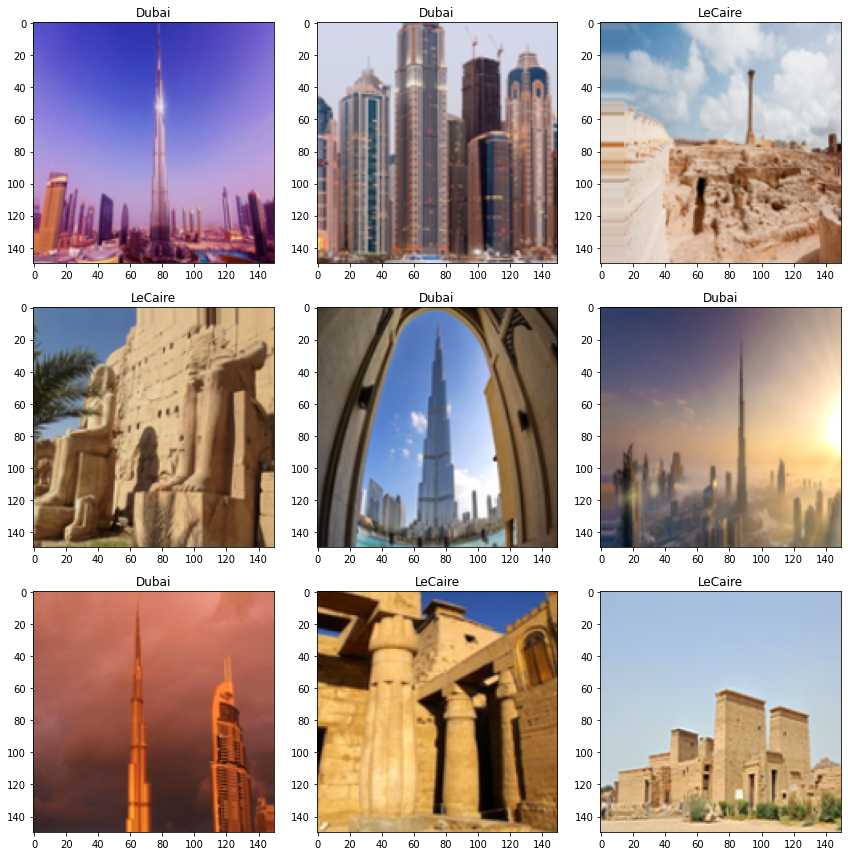

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(2500)
shuffle_indices = shuffle_indices
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(denormalize(image)/255)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers, regularizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, SpatialDropout2D
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
lambda_l1 = 0.01
lambda_l2 = 0.03

model = models.Sequential()
model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,(3, 3), activation='relu'))
#model.add(SpatialDropout2D(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96,(3, 3), activation='relu'))
#model.add(SpatialDropout2D(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(3, 3), activation='relu'))
#model.add(SpatialDropout2D(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=lambda_l1, l2=lambda_l2)))   # Couche dense, à 512 neurones
model.add(Dropout(0.5))                  #25% Dropout
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=lambda_l1, l2=lambda_l2)))   # Couche dense, à 512 neurones
model.add(Dropout(0.5))                  #25% Dropout
model.add(Dense(6, activation='softmax'))   # Couche de sortie

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

Early Stopping & Model Checkpoint

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=100,callbacks=[es,mc])

Epoch 1/100
88/88 [==============================] - 43s 103ms/step - loss: 386.6283 - acc: 0.2559 - val_loss: 48.7903 - val_acc: 0.3361

Epoch 00001: val_acc improved from -inf to 0.33609, saving model to best_model.h5
Epoch 2/100
88/88 [==============================] - 8s 86ms/step - loss: 34.3691 - acc: 0.4120 - val_loss: 15.4113 - val_acc: 0.4864

Epoch 00002: val_acc improved from 0.33609 to 0.48637, saving model to best_model.h5
Epoch 3/100
88/88 [==============================] - 8s 87ms/step - loss: 12.1760 - acc: 0.4609 - val_loss: 5.1447 - val_acc: 0.4855

Epoch 00003: val_acc did not improve from 0.48637
Epoch 4/100
88/88 [==============================] - 8s 87ms/step - loss: 4.1392 - acc: 0.4843 - val_loss: 2.8496 - val_acc: 0.4889

Epoch 00004: val_acc improved from 0.48637 to 0.48885, saving model to best_model.h5
Epoch 5/100
88/88 [==============================] - 8s 87ms/step - loss: 2.7777 - acc: 0.4946 - val_loss: 2.6897 - val_acc: 0.4955

Epoch 00005: val_acc impr

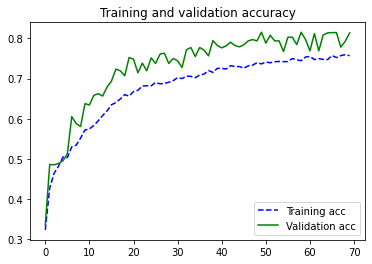

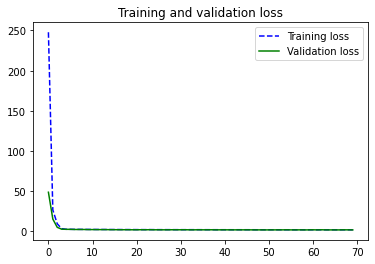

In [ ]:

plot_training_analysis()